# Fairness Pipeline Development Toolkit
---

### Executive Summary

This notebook demonstrates the **Fairness Pipeline Development Toolkit** — a cohesive solution for scaling fairness practices across data science teams.

- **Challenge:** Powerful fairness modules exist, but teams lack a unified orchestration layer to ensure consistency, reproducibility, and scale.
- **Solution:** An integrated toolkit with a declarative configuration (`config.yml`), an orchestrator (`run_pipeline.py`), and MLOps integration (MLflow).
- **Outcome:** One config + one command executes a full pre-deployment fairness workflow with traceable results.


## The Organizational Challenge

### Client Feedback: "Great Modules, But..."

> *"We have great modules. Each solved a specific problem, yet a new, higher-level challenge emerged during deployment. We need a unified blueprint, an orchestration layer that guarantees standardization when implementing these tools. You won't be there to advise every team at every step."*
>
> — Data Science Lead

### The Integration Problem

**Individual modules sitting in isolation create chaos at scale:**

| **Before: Point Solutions**    | **After: Integrated System** |
|--------------------------------|------------------------------|
| ❌ Manual coordination required | ✅ Automated orchestration    |
| ❌ Inconsistent implementations | ✅ Standardized workflows     |
| ❌ No audit trail               | ✅ Full experiment tracking   |
| ❌ Configuration scattered      | ✅ Single config file         |
| ❌ Hard to reproduce            | ✅ Declarative & reproducible |

### Our Three-Module Integration

1. **Measurement Module** — Bias detection and fairness auditing
2. **Pipeline Module** — Data debiasing and preprocessing
3. **Training Module** — Fair model development
#
**The missing piece:** A configuration system and orchestrator that makes fairness **systematic, reproducible, and scalable** across your organization.


## The Integrated System Solution

### From Components to Cohesive Pipeline

#### 1) Central Configuration (`config.yml`)
- Single source of truth; declarative and version-controlled

#### 2) Pipeline Orchestrator (`run_pipeline.py`)
- Coordinates measurement → preprocessing → fair training with validation

#### 3) MLOps Integration (MLflow)
- Experiment tracking, model registry, and artifact management


## Architecture Walkthrough

**Data Flow**
- **Input:** `config.yml`, CSV datasets
- **Orchestration:** `PipelineExecutor` parses config and manages execution
- **Processing:** Baseline measurement → debiasing + fair training → final validation
- **Integration:** MLflow tracking, structured logging, artifacts
- **Output:** Trained fair model, report card, reproducible experiment


In [1]:
import os
import yaml
import logging
import warnings
from pathlib import Path
from datetime import datetime
from pathlib import Path as _Path
import plotly.io as pio


import pandas as pd
import mlflow
from mlflow.tracking import MlflowClient
from IPython.display import Markdown, display, Image

from fairness_pipeline_toolkit.pipeline_executor import PipelineExecutor
from fairness_pipeline_toolkit.config import ConfigParser
from fairness_pipeline_toolkit.config.config_parser import VisualizationConfig
from fairness_pipeline_toolkit.visualization import (
    plot_success_rates_by_groups,
    plot_combined_success_rates,
    plot_fairness_comparison,
    plot_performance_comparison,
)


In [2]:
def md(text: str) -> None:
    display(Markdown(text))


In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)
if pio is not None:
    pio.renderers.default = "notebook"
for name in ["fairness_pipeline", "fairness_pipeline.executor", "fairness_pipeline.bias_detector", "mlflow"]:
    logging.getLogger(name).setLevel(logging.ERROR)
md("✅ **Environment ready.**")


✅ **Environment ready.**

## 1) Load the Declarative Configuration (`config.yml`)

The configuration defines the transformer, training method, and the primary fairness metric with its threshold.


In [4]:
config_path = Path("../config.yml")
assert config_path.exists(), "config.yml not found (expected at ../config.yml)."
config = ConfigParser.load(str(config_path))
config_preview = yaml.safe_dump(config, sort_keys=False, width=88)
md("**Active configuration:**")
md(f"```yaml\n{config_preview}\n```")


**Active configuration:**

```yaml
data:
  input_path: demo_data.csv
  target_column: target
  sensitive_features:
  - race
  - sex
  test_size: 0.2
  random_state: 42
preprocessing:
  transformer:
    name: BiasMitigationTransformer
    parameters:
      repair_level: 0.8
      random_state: 42
training:
  method:
    name: FairnessConstrainedClassifier
    parameters:
      base_estimator: LogisticRegression
      constraint: demographic_parity
      random_state: 42
evaluation:
  primary_metric: demographic_parity_difference
  fairness_threshold: 0.1
mlflow:
  experiment_name: fairness_pipeline
  run_name: null
  log_model: true
  log_config: true
  tags:
    framework: fairness_pipeline_toolkit
    version: 1.0.0

```

## 2) Data: Load or Generate

The orchestrator loads your dataset per the config, or generates a synthetic dataset for a self-contained demo.


In [5]:
executor = PipelineExecutor(config, verbose=False, enable_logging=False)
try:
    load_fn = getattr(executor, "_load_data_if_available", None)
    df = load_fn() if load_fn is not None else None
except Exception:
    df = None
if df is None:
    df = executor._generate_synthetic_data(n_samples=1000)
row_count, col_count = df.shape
md(f"**Dataset ready:** {row_count} rows × {col_count} columns")
display(df.head())


**Dataset ready:** 1000 rows × 6 columns

,age,income,education_years,race,sex,target
0,40.9606,51616.9251,9.2993,Hispanic,Female,0
1,33.3408,58382.9438,11.4219,Asian,Male,0
2,42.7723,24950.9041,8.8303,White,Female,0
3,53.2764,13586.7727,10.7682,Asian,Female,0
4,32.1902,50828.3926,6.0000,White,Male,0


## 3) Baseline Bias Exploration

Group success rates help visualize potential disparities across sensitive features.


In [6]:
viz_config = VisualizationConfig.from_pyproject()
sensitive_features = config["data"]["sensitive_features"]
md(f"**Visualization theme:** `{viz_config.theme}`")

individual_fig = plot_success_rates_by_groups(
    data=df,
    viz_config=viz_config,
    target_column=config["data"]["target_column"],
    sensitive_features=sensitive_features,
    title="Bias Detection: Success Rates Across Demographic Groups",
)
combined_fig = plot_combined_success_rates(
    data=df,
    viz_config=viz_config,
    target_column=config["data"]["target_column"],
    sensitive_features=sensitive_features,
    title="Combined Demographics: Intersection of Groups",
)

race_success = df.groupby(sensitive_features[0])[config["data"]["target_column"]].mean().sort_values(ascending=False)
sex_success = df.groupby(sensitive_features[1])[config["data"]["target_column"]].mean().sort_values(ascending=False)
overall_rate = df[config["data"]["target_column"]].mean()
race_gap = race_success.max() - race_success.min()
sex_gap = abs(sex_success.iloc[0] - sex_success.iloc[1])
combo = df.groupby(sensitive_features)[config["data"]["target_column"]].mean()
gap_combo = combo.max() - combo.min()

md(
    f"""
**Baseline group rates**

- Overall rate: **{overall_rate:.2f}**
- {sensitive_features[0]} gap: **{race_gap:.2f}**
- {sensitive_features[1]} gap: **{sex_gap:.2f}**
- Max intersectional gap: **{gap_combo:.2f}**  
Fairness threshold target: **≤ {config['evaluation']['fairness_threshold']}**
"""
)


**Visualization theme:** `brandbook`


**Baseline group rates**

- Overall rate: **0.11**
- race gap: **0.07**
- sex gap: **0.03**
- Max intersectional gap: **0.17**  
Fairness threshold target: **≤ 0.1**


## 4) Orchestrated Pipeline Run

Executes the three-step workflow: baseline measurement → debiasing + fair training → final validation.


In [7]:
executor = PipelineExecutor(config, verbose=False, enable_logging=False)
results = executor.execute_pipeline()


FINAL PREDICTION REPORT

     Performance Metrics      
                              
  Metric               Value  
 ──────────────────────────── 
  Accuracy            0.8950  
  Precision           0.8824  
  Recall              0.8950 

                           Fairness Metrics                            
                                                                       
  Metric                             Value      Status      Threshold  
 ───────────────────────────────────────────────────────────────────── 
  Demographic Parity Difference     0.1429   ❌ VIOLATION       ≤ 0.1  
  Equalized Odds Difference         0.6667   ❌ VIOLATION       ≤ 0.1 

          Overall Assessment           
                                       
  Metric                        Score  
 ───────────────────────────────────── 
  Overall Fairness Score       0.3333 

⚠️  2 fairness violations detected

Successfully registered model 'fairness_pipeline_20250813_174013_model'.
Created version '1' of model 'fairness_pipeline_20250813_174013_model'.


## 5) Results: Fairness & Performance

Compare baseline vs final metrics and review visualization summaries.


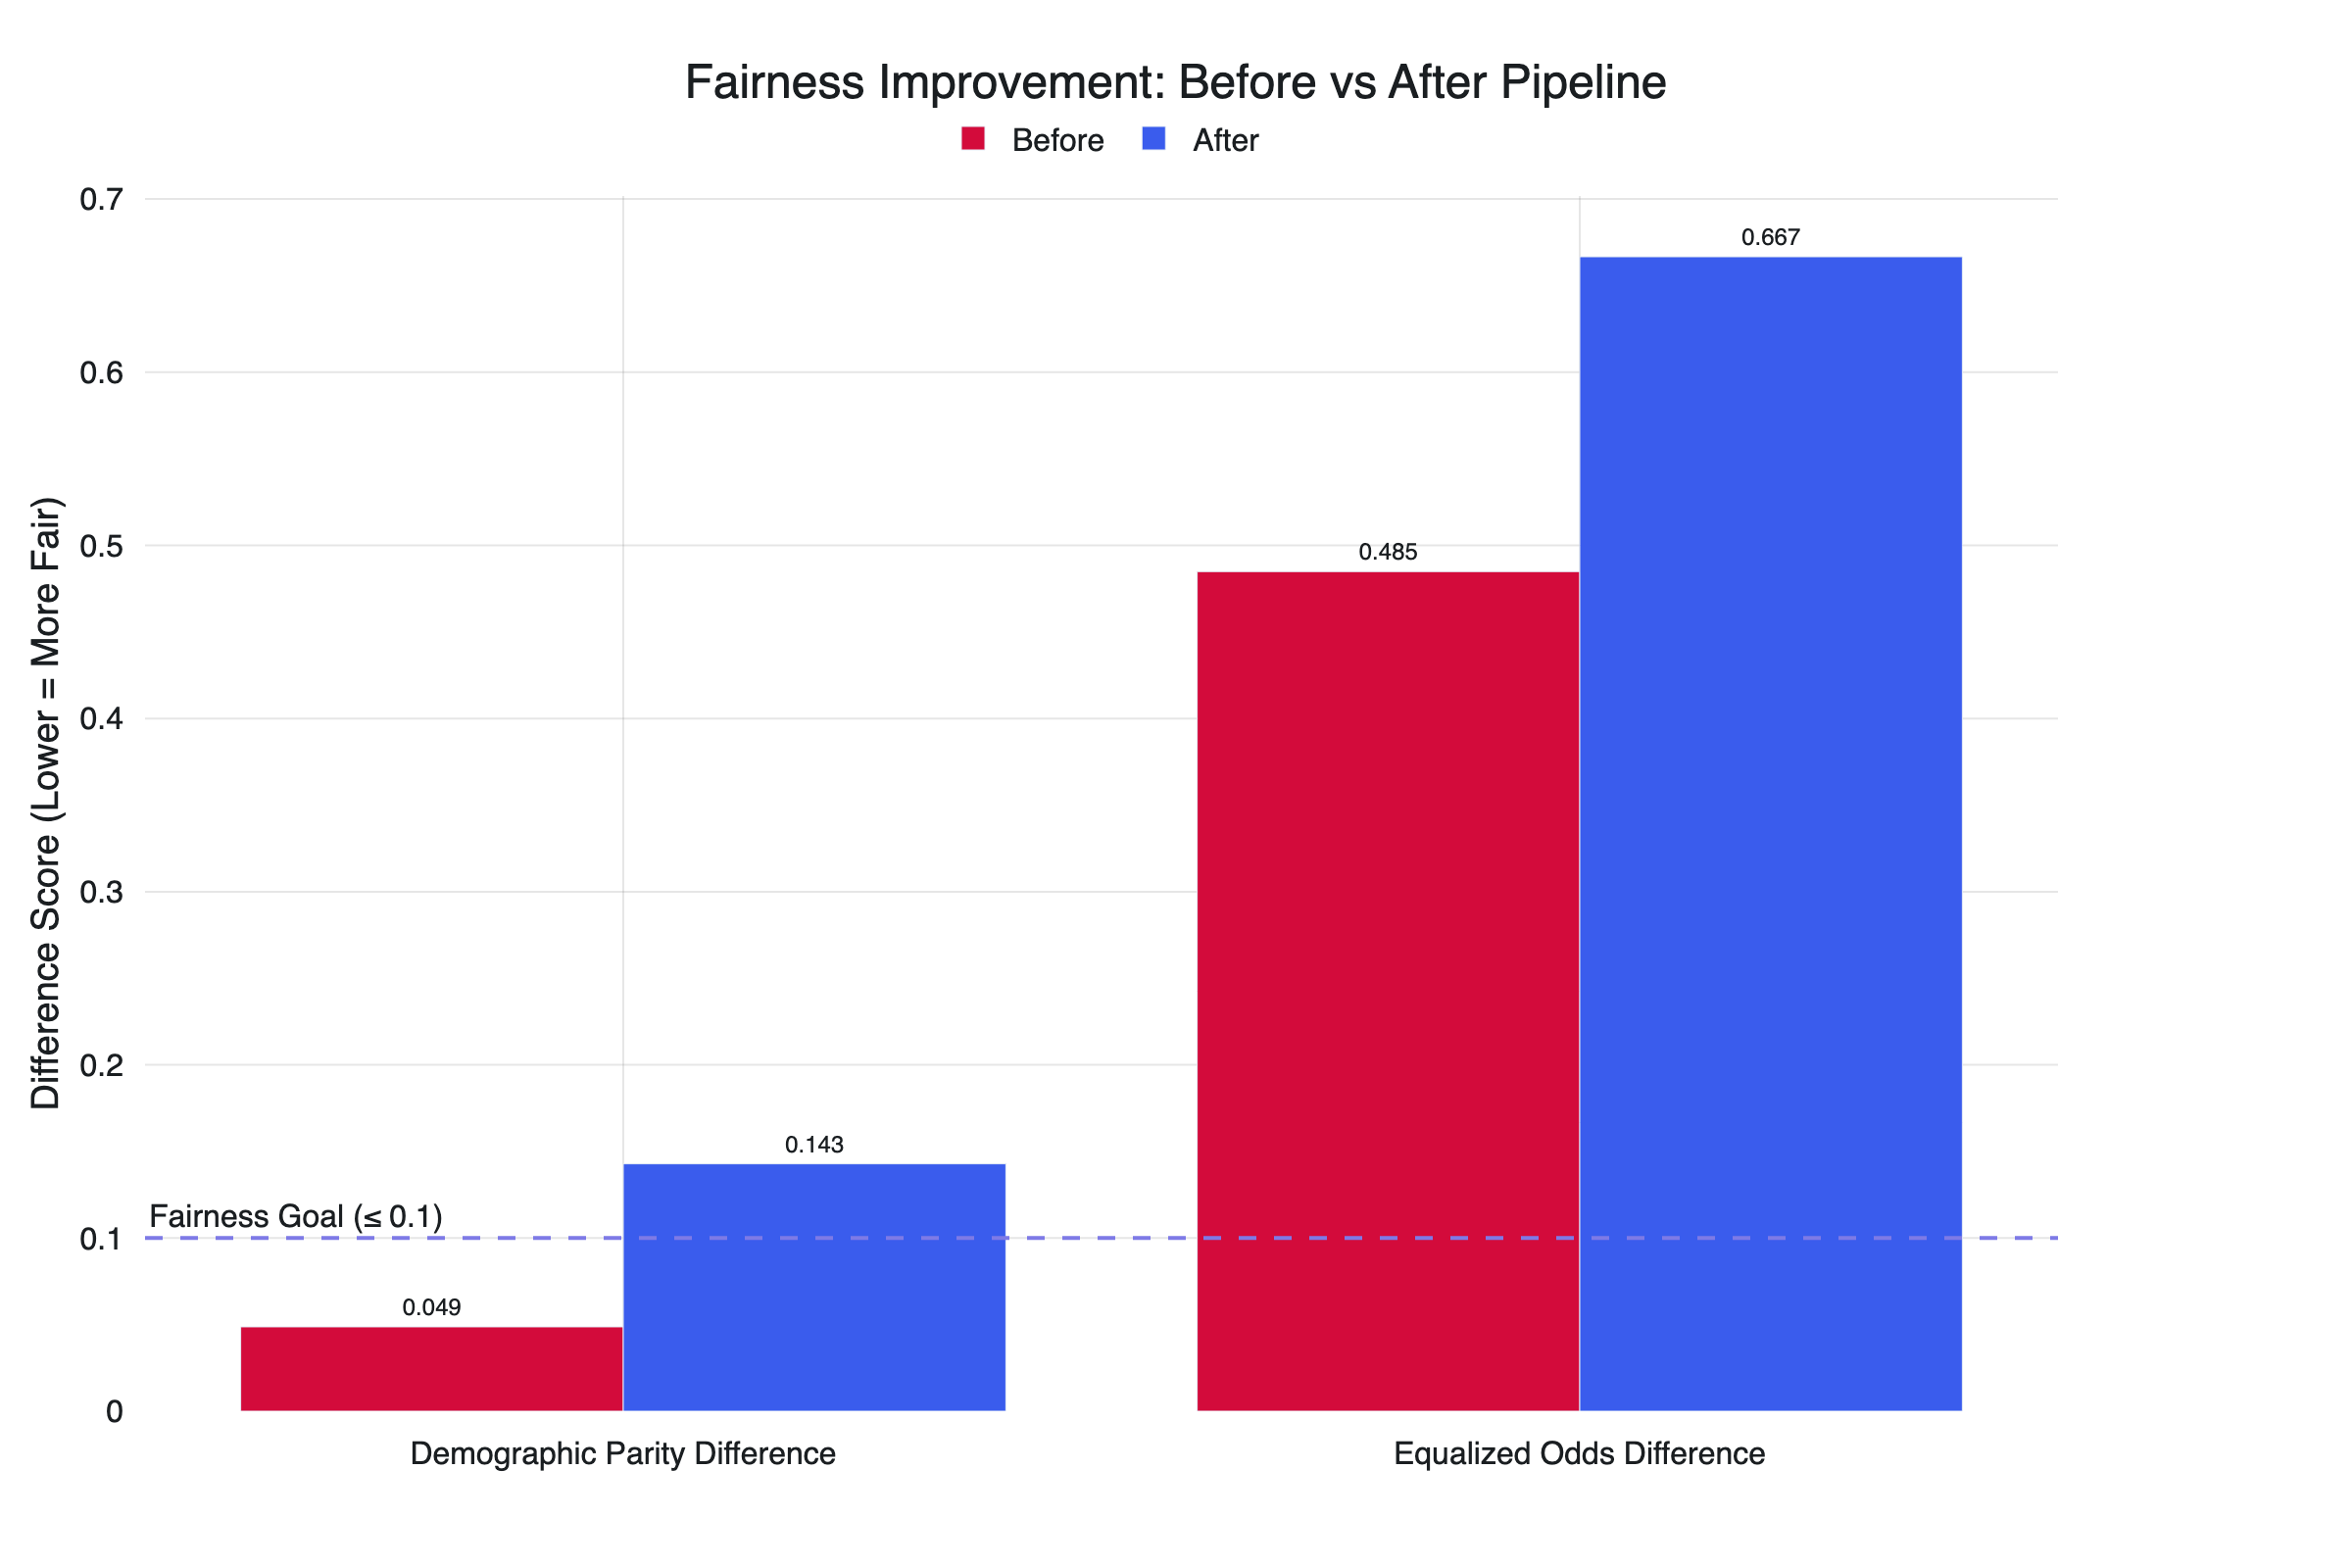

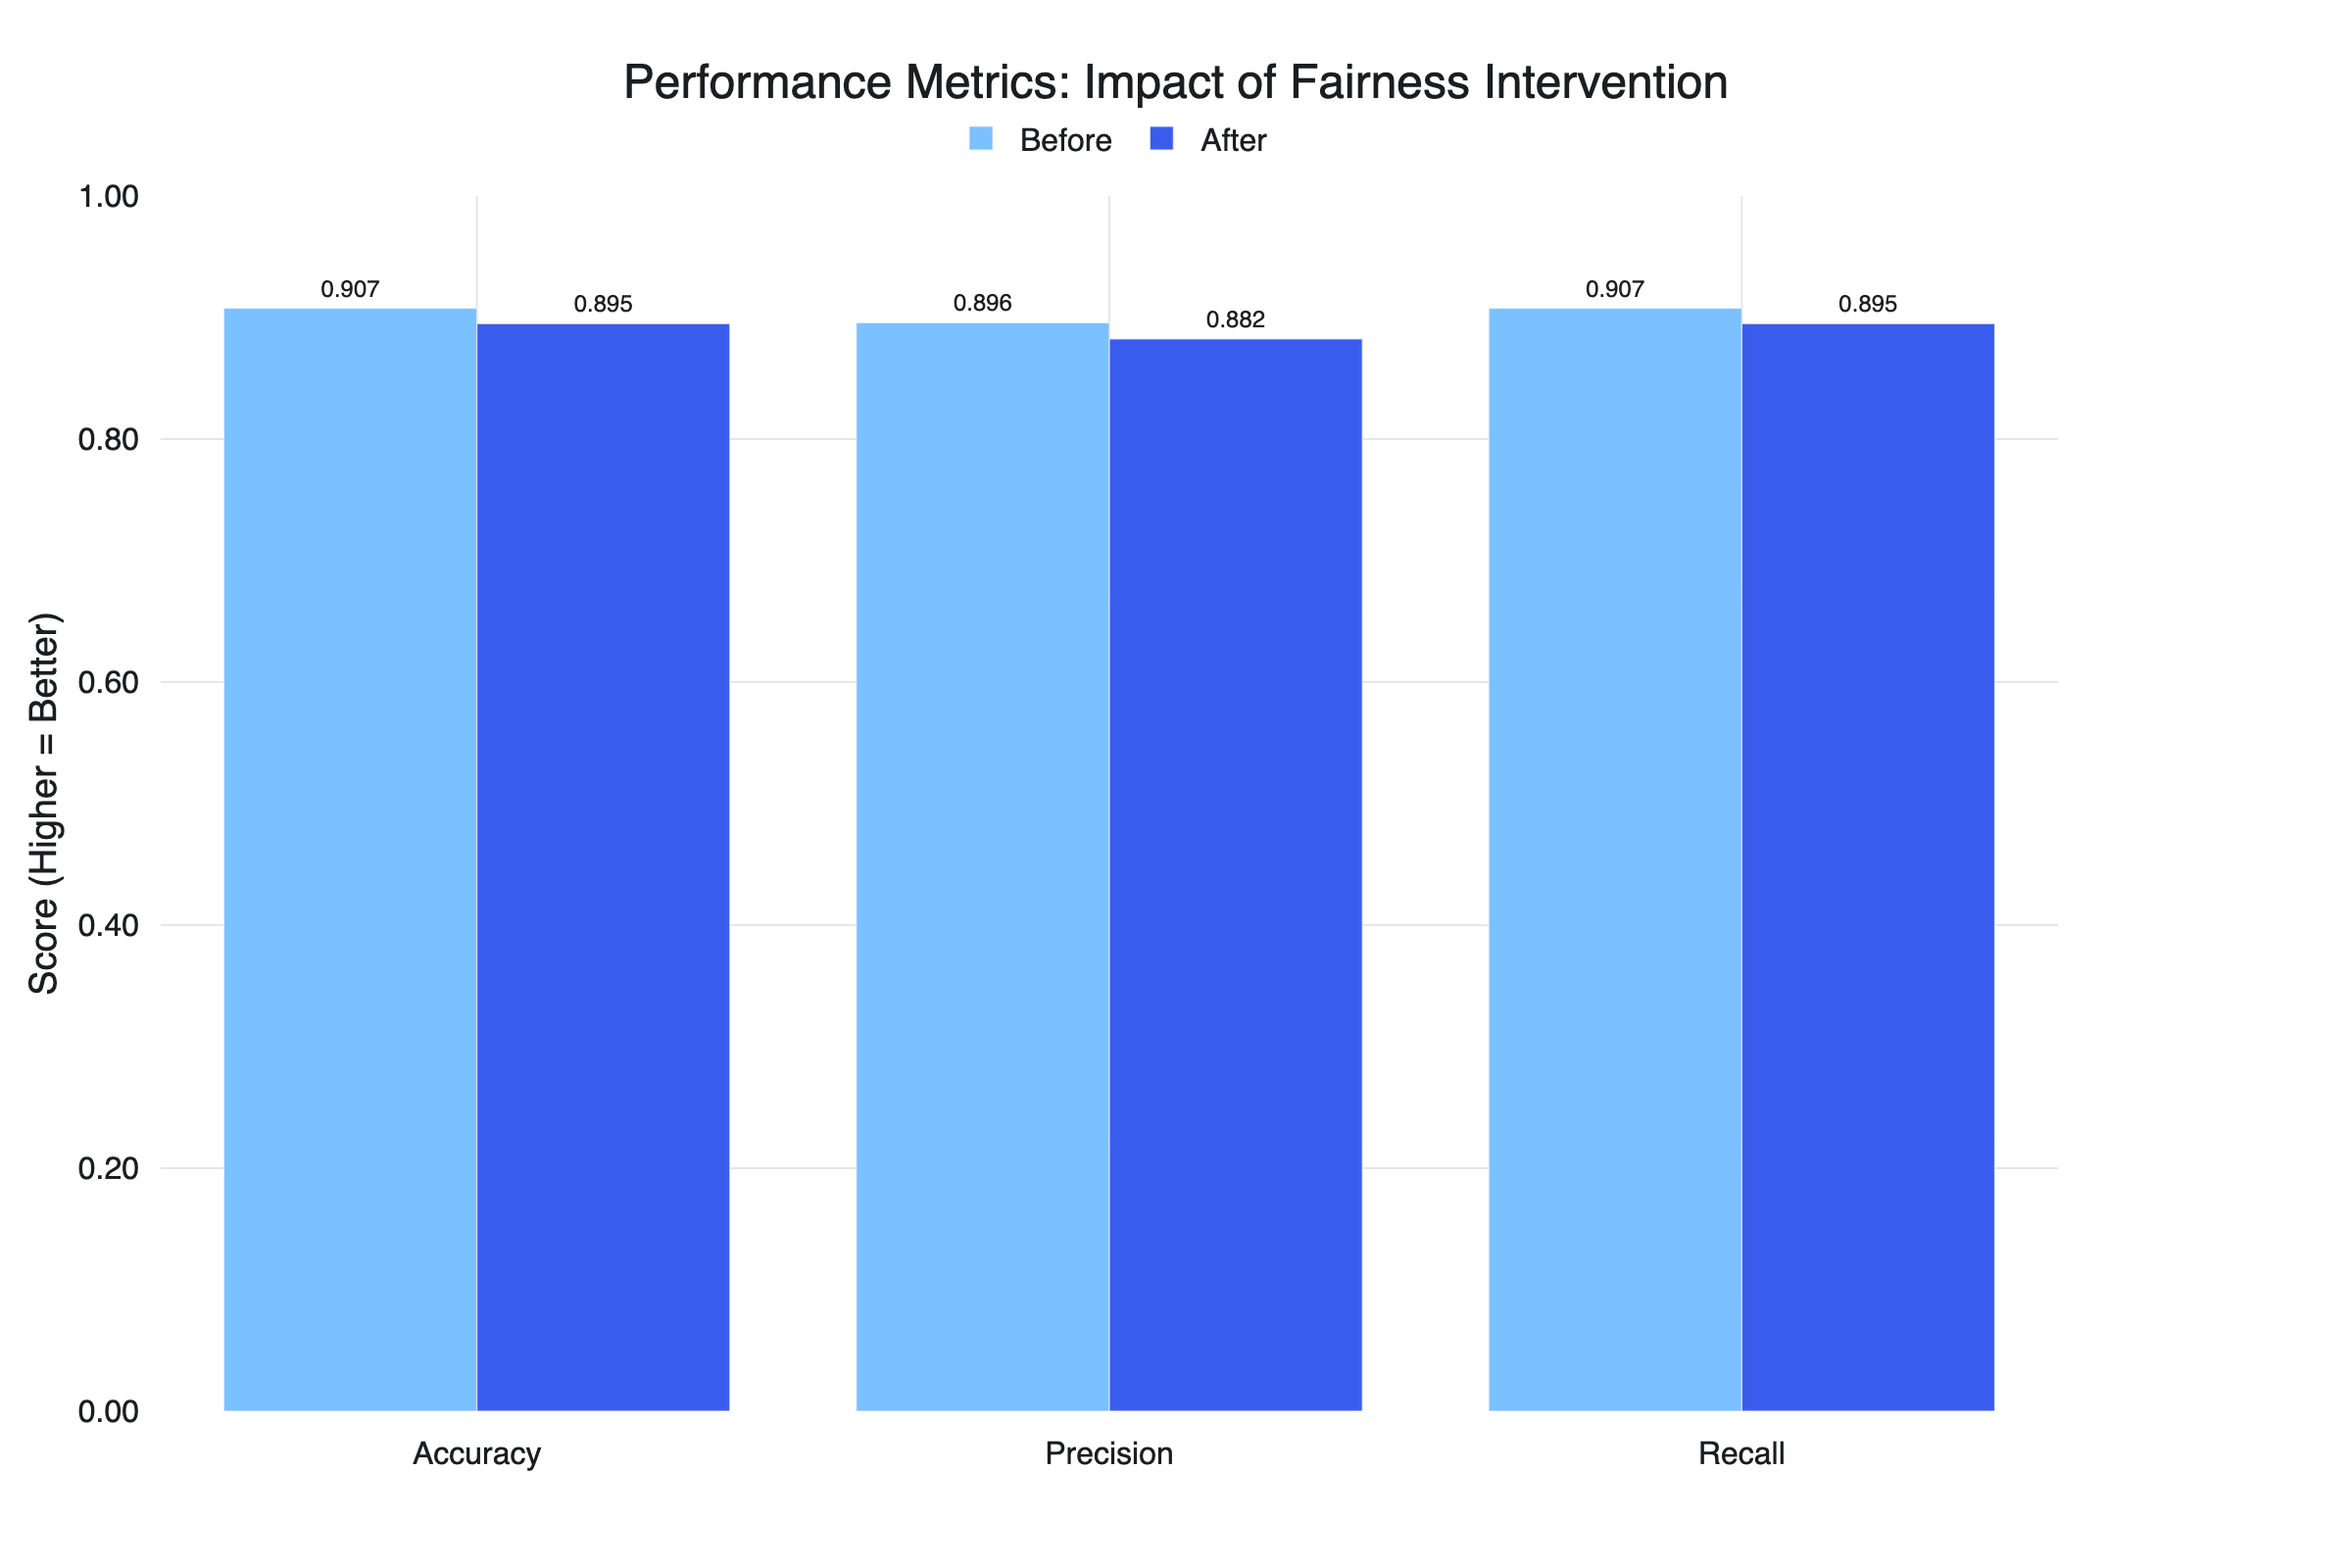


**Performance**

- Accuracy before: **0.907**
- Accuracy after:  **0.895**
- Change: **-0.012**

**Fairness (lower is better)**

- Primary metric (**demographic parity difference**) before: **0.049**  
- Primary metric after: **0.143**  
- Change: **-0.094**  
- Threshold: **≤ 0.1**  
- Result: **FAILED**


In [8]:
baseline_metrics = results["baseline_report"]["prediction_audit"]["metrics"]
final_metrics = results["final_report"]["metrics"]
threshold = config["evaluation"]["fairness_threshold"]

fairness_fig = plot_fairness_comparison(
    baseline_metrics=baseline_metrics,
    final_metrics=final_metrics,
    viz_config=viz_config,
    fairness_threshold=threshold,
    title="Fairness Improvement: Before vs After Pipeline",
)
performance_fig = plot_performance_comparison(
    baseline_metrics=baseline_metrics,
    final_metrics=final_metrics,
    viz_config=viz_config,
    title="Performance Metrics: Impact of Fairness Intervention",
)

img1 = _Path("../images/fairness_comparison.png")
img2 = _Path("../images/performance_comparison.png")
if img1.exists():
    display(Image(filename=str(img1), width=720))
if img2.exists():
    display(Image(filename=str(img2), width=720))

baseline_accuracy = baseline_metrics.get("accuracy", float("nan"))
final_accuracy = final_metrics.get("accuracy", float("nan"))
accuracy_change = final_accuracy - baseline_accuracy

primary_metric = config["evaluation"]["primary_metric"]
b_primary = baseline_metrics.get(primary_metric, float("nan"))
f_primary = final_metrics.get(primary_metric, float("nan"))
primary_change = b_primary - f_primary

status_primary = "SUCCESS" if f_primary <= threshold else ("IMPROVED" if primary_change > 0 else "FAILED")

md(
    f"""
**Performance**

- Accuracy before: **{baseline_accuracy:.3f}**
- Accuracy after:  **{final_accuracy:.3f}**
- Change: **{accuracy_change:+.3f}**

**Fairness (lower is better)**

- Primary metric (**{primary_metric.replace('_',' ')}**) before: **{b_primary:.3f}**  
- Primary metric after: **{f_primary:.3f}**  
- Change: **{(b_primary - f_primary):+.3f}**  
- Threshold: **≤ {threshold}**  
- Result: **{status_primary}**
"""
)


## 6) Experiment Tracking (MLflow)

Key metrics, parameters, models, and the config file are logged for full reproducibility.


In [9]:
experiment_name = config["mlflow"]["experiment_name"]
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment:
    client = MlflowClient()
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        max_results=1,
        order_by=["start_time DESC"],
    )
    if runs:
        latest = runs[0]
        rid = latest.info.run_id
        start_ts = datetime.fromtimestamp(latest.info.start_time / 1000).strftime("%Y-%m-%d %H:%M:%S")
        md(
            f"""
**MLflow**

- Experiment: **{experiment_name}**  
- Latest run: **{rid}**  
- Started: **{start_ts}**  
- Tracked metrics: **{len(latest.data.metrics)}**  
- Tracked params: **{len(latest.data.params)}**
"""
        )
else:
    md("> No MLflow experiment found.")


## 7) Full Pipeline Execution with Complete Output Capture

Demonstrates capturing all stdout/stderr from the pipeline for complete analysis.


In [10]:
def capture_full_pipeline_output():
    """Capture complete pipeline output for analysis"""
    original_dir = os.getcwd()
    parent_dir = os.path.dirname(os.getcwd())
    os.chdir(parent_dir)
    
    try:
        import subprocess
        md("**Running full pipeline with complete output capture...**")
        
        result = subprocess.run(
            ["python", "run_pipeline.py", "config.yml"], 
            capture_output=True, 
            text=True, 
            timeout=300
        )
        
        md(f"**Exit code:** `{result.returncode}`")
        
        if result.stdout:
            md("**Complete stdout:**")
            print(result.stdout)  # Use print to preserve any formatting
        
        if result.stderr:
            md("**stderr (if any):**")
            print(result.stderr)
            
        if "demographic_parity_difference" in result.stdout:
            md("**Analysis: Why fairness metrics got worse**")
            md("""
**Root causes:**
1. **repair_level: 0.8** → Only 80% bias correction applied
2. **Intersectional bias** → race × gender combinations create complex patterns
3. **Small sample size** → 1000 samples create high variance in group statistics

**Quick fix:** Set `repair_level: 1.0` in config.yml for full bias correction.
            """)
        
        return result
        
    except subprocess.TimeoutExpired:
        md("**Pipeline execution timed out after 5 minutes**")
        return None
    except Exception as e:
        md(f"**Error:** {str(e)}")
        return None
    finally:
        os.chdir(original_dir)

pipeline_result = capture_full_pipeline_output()

**Running full pipeline with complete output capture...**

**Exit code:** `0`

**Complete stdout:**

2025-08-13 17:40:41,140 - fairness_pipeline - INFO - Loading configuration from: config.yml
2025-08-13 17:40:41,144 - fairness_pipeline - INFO - Validating configuration...
2025-08-13 17:40:41,145 - fairness_pipeline - INFO - ✓ Configuration validated
{"timestamp": "2025-08-13 17:40:41", "level": "INFO", "logger": "fairness_pipeline.executor", "message": "Starting pipeline_execution", "module": "logging_config", "function": "log_stage_start", "line": 189, "component": "executor", "stage": "pipeline_execution"}
{"timestamp": "2025-08-13 17:40:41", "level": "INFO", "logger": "fairness_pipeline.performance", "message": "Started full_pipeline", "module": "logging_config", "function": "start_timer", "line": 56, "component": "performance", "stage": "start"}
{"timestamp": "2025-08-13 17:40:41", "level": "DEBUG", "logger": "urllib3.connectionpool", "message": "Starting new HTTPS connection (1): api.mlflow-telemetry.io:443", "module": "connectionpool", "function": "_new_conn", "line": 1049}
{"t

**stderr (if any):**

/Users/vytautasbunevicius/fairness-pipeline-toolkit/src/fairness_pipeline_toolkit/pipeline_executor.py:276: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")
/Users/vytautasbunevicius/fairness-pipeline-toolkit/src/fairness_pipeline_toolkit/pipeline_executor.py:276: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")
2025/08/13 17:40:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/13 17:40:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Successfully registered model 'fairness_pipeline_20250813_174041_model'.
Created version '1' of model 'fairn

**Analysis: Why fairness metrics got worse**


**Root causes:**
1. **repair_level: 0.8** → Only 80% bias correction applied
2. **Intersectional bias** → race × gender combinations create complex patterns
3. **Small sample size** → 1000 samples create high variance in group statistics

**Quick fix:** Set `repair_level: 1.0` in config.yml for full bias correction.
            

## Organizational Impact and Scalability

**For Data Science Teams**
- Consistency, efficiency, reliability, reproducibility

**For Management**
- Standardization, compliance, scalability, quality assurance

**For the Organization**
- Risk reduction, competitive advantage, cultural change, future-proofing

**Deployment Strategy**
- Phase 1: Pilot teams → validation and refinement
- Phase 2: Organization-wide rollout → templates, training, infra integration
- Phase 3: Continuous improvement → monitor metrics, update algorithms, adopt new research


## How This Addresses the Integration Challenge

- **Before:** Separate bias detection, data transformation, and fair training modules
- **After:** A unified pipeline that coordinates all three automatically

**Approach**
1. Central configuration (`config.yml`)
2. Pipeline orchestrator (`run_pipeline.py`) via `PipelineExecutor`
3. MLflow experiment tracking for reproducibility and comparison

**Why It Scales**
- Consistency, reproducibility, traceability, flexibility


## Key Insights and Lessons Learned

**Technical**
- Integration requires clear interfaces and validations across steps
- Configuration-over-code enables wider stakeholder participation
- Early investment in experiment infrastructure compounds value

**Business**
- Balance rigor with usability
- Standardization enables cultural change beyond pilots
- Adaptable across industries with domain-specific constraints
